
# Construction of Regression Models using Data

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Notebook version: 2.1 (Sep 27, 2019)

    Changes: v.1.0 - First version. Extracted from regression_intro_knn v.1.0.
             v.1.1 - Compatibility with python 2 and python 3
             v.2.0 - New notebook generated. Fuses code from Notebooks R1, R2, and R3
             v.2.1 - Updated index notation

In [2]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import numpy as np
import scipy.io       # To read matlab files
import pandas as pd   # To read data tables from csv files

# For plots and graphical results
import matplotlib                 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import pylab

# For the student tests (only for python 2)
import sys
if sys.version_info.major==2:
    from test_helper import Test

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6  


## 1. The regression problem

The goal of regression methods is to predict the value of some *target* variable $S$ from the observation of one or more *input* variables $X_0, X_1, \ldots, X_{K-1}$ (that we will collect in a single vector $\bf X$).

Regression problems arise in situations where the value of the target variable is not easily accessible, but we can measure other dependent variables, from which we can try to predict $S$.  
<img src="figs/block_diagram.png" width=600>

The only information available to estimate the relation between the inputs and the target is a *dataset* $\mathcal D$ containing several observations of all variables.

$$\mathcal{D} = \{{\bf x}_k, s_k\}_{k=0}^{K-1}$$

The dataset $\mathcal{D}$ must be used to find a function $f$ that, for any observation vector ${\bf x}$, computes an output $\hat{s} = f({\bf x})$ that is a good predition of the true value of the target, $s$.

<img src="figs/predictor.png" width=300>

Note that for the generation of the regression model, we exploit the statistical dependence between random variable $S$ and random vector ${\bf X}$. In this respect, we can assume that the available dataset $\mathcal{D}$ consists of i.i.d. points from the joint distribution $p_{S,{\bf X}}(s,{\bf x})$. If we had access to the true distribution, a statistical approach would be more accurate; however, in many situations such knowledge is not available, but using training data to do the design is feasible (e.g., relying on historic data, or by manual labelling of a set of patterns).

## 2. Examples of regression problems.

The <a href=http://scikit-learn.org/>scikit-learn</a> package contains several <a href=http://scikit-learn.org/stable/datasets/> datasets</a> related to regression problems. 

* <a href=http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston > Boston dataset</a>: the target variable contains housing values in different suburbs of Boston. The goal is to predict these values based on several social, economic and demographic variables taken frome theses suburbs (you can get more details in the <a href = https://archive.ics.uci.edu/ml/datasets/Housing > UCI repository </a>).


* <a href=http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes /> Diabetes dataset</a>.

We can load these datasets as follows:

In [3]:
from sklearn import datasets

# Load the dataset. Select it by uncommenting the appropriate line
D_all = datasets.load_boston()
#D_all = datasets.load_diabetes()

# Extract data and data parameters.
X = D_all.data         # Complete data matrix (including input and target variables)
S = D_all.target      # Target variables
n_samples = X.shape[0] # Number of observations
n_vars = X.shape[1]    # Number of variables (including input and target)

This dataset contains 

In [4]:
print(n_samples)

506


observations of the target variable and

In [5]:
print(n_vars)

13


input variables.

## 3. Scatter plots

### 3.1. 2D scatter plots

When the instances of the dataset are multidimensional, they cannot be visualized directly, but we can get a first rough idea about the regression task if we plot the target variable versus one of the input variables. These representations are known as <i>scatter plots</i>

Python methods `plot` and `scatter` from the `matplotlib` package can be used for these graphical representations.


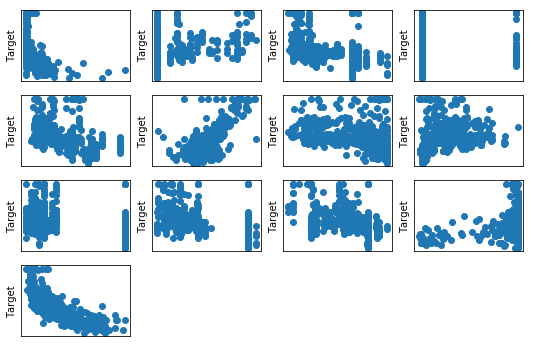

In [6]:
# Select a dataset
nrows = 4
ncols = 1 + (X.shape[1]-1)/nrows

# Some adjustment for the subplot.
pylab.subplots_adjust(hspace=0.2)

# Plot all variables
for idx in range(X.shape[1]):
    ax = plt.subplot(nrows,ncols,idx+1)
    ax.scatter(X[:,idx], S)    # <-- This is the key command
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.ylabel('Target')
    


## 4. Evaluating a regression task

In order to evaluate the performance of a given predictor, we need to quantify the quality of predictions. This is usually done by means of a loss function $l(s,\hat{s})$. Two common losses are

   - Square error: $l(s, \hat{s}) = (s - \hat{s})^2$
   - Absolute error: $l(s, \hat{s}) = |s - \hat{s}|$

Note that both the square and absolute errors are functions of the estimation error $e = s-{\hat s}$. However, this is not necessarily the case. As an example, imagine a situation in which we would like to introduce a penalty which increases with the magnitude of the estimated variable. For such case, the following cost would better fit our needs: $l(s,{\hat s}) = s^2 \left(s-{\hat s}\right)^2$.

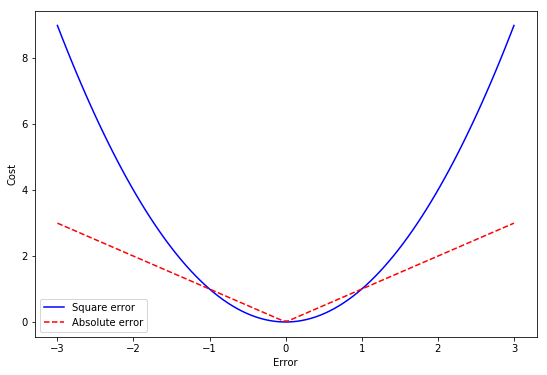

In [7]:
# In this section we will plot together the square and absolute errors
grid = np.linspace(-3,3,num=100)
plt.plot(grid, grid**2, 'b-', label='Square error')
plt.plot(grid, np.absolute(grid), 'r--', label='Absolute error')
plt.xlabel('Error')
plt.ylabel('Cost')
plt.legend(loc='best')
plt.show()

In general, we do not care much about an isolated application of the regression model, but instead, we are looking for a generally good behavior, for which we need to average the loss function over a set of samples. In this notebook, we will use the average of the square loss, to which we will refer as the `mean-square error` (MSE).

$$\text{MSE} = \frac{1}{K}\sum_{k=0}^{K-1} \left(s^{(k)}- {\hat s}^{(k)}\right)^2$$

The following code fragment defines a function to compute the MSE based on the availability of two vectors, one of them containing the predictions of the model, and the other the true target values.

In [7]:
# We start by defining a function that calculates the average square error
def square_error(s, s_est):
    # Squeeze is used to make sure that s and s_est have the appropriate dimensions.
    y = np.mean(np.power((np.squeeze(s) - np.squeeze(s_est)), 2))
    return y

### 4.1. Training and test data

The major goal of the regression problem is that the predictor should make good predictions for arbitrary new inputs, not taken from the dataset used by the regression algorithm. 

Thus, in order to evaluate the prediction accuracy of some regression algorithm, we need some data, not used during the predictor design, to *test* the performance of the predictor under new data. To do so, the original dataset is usually divided in (at least) two disjoint sets:

* **Training set**, $\cal{D}_{\text{train}}$: Used by the regression algorithm to determine predictor $f$.
* **Test set**, $\cal{D}_{\text{test}}$: Used to evaluate the performance of the regression algorithm.

A good regression algorithm uses $\cal{D}_{\text{train}}$ to obtain a predictor with small average loss based on $\cal{D}_{\text{test}}$
$$
{\bar R}_{\text{test}} = \frac{1}{K_{\text{test}}} 
\sum_{  ({\bf x},s) \in \mathcal{D}_{\text{test}}} l(s, f({\bf x}))
$$
where $K_{\text{test}}$ is the size of the test set.

As a designer, you only have access to training data. However, for illustration purposes, you may be given a test dataset for many examples in this course. Note that in such a case, using the test data to adjust the regression model is completely forbidden. You should work as if such test data set were not available at all, and recur to it just to assess the performance of the model after the design is complete.

To model the availability of a train/test partition, we split next the boston dataset into a training and test partitions, using 60% and 40% of the data, respectively.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, s_train, s_test = train_test_split(X, S, test_size=0.4, random_state=0)

### 4.2. A first example: A baseline regression model

A first very simple method to build the regression model is to use the average of all the target values in the training set as the output of the model, discarding the value of the observation input vector.

This approach can be considered as a baseline, given that any other method making an effective use of the observation variables, statistically related to $s$, should improve the performance of this method.

The following code fragment uses the train data to compute the baseline regression model, and it shows the MSE calculated over the test partitions.

In [9]:
S_baseline = np.mean(s_train)

print('The baseline estimator is:', S_baseline)

#Compute MSE for the train data
#MSE_train = square_error(s_train, S_baseline)

#Compute MSE for the test data. IMPORTANT: Note that we still use
#S_baseline as the prediction.
MSE_test = square_error(s_test, S_baseline)

#print('The MSE for the training data is:', MSE_train)
print('The MSE for the test data is:', MSE_test)

The baseline estimator is: 22.7465346535
The MSE for the test data is: 83.0143622257


## 5. Parametric and non-parametric regression models

Generally speaking, we can distinguish two approaches when designing a regression model:

   - Parametric approach: In this case, the estimation function is given <i>a priori</i> a parametric form, and the goal of the design is to find the most appropriate values of the parameters according to a certain goal
   
   For instance, we could assume a linear expression
   $${\hat s} = f({\bf x}) = {\bf w}^\top {\bf x}$$
   and adjust the parameter vector in order to minimize the average of the quadratic error over the training data. This is known as least-squares regression, and we will study it in Section 8 of this notebook.
   
   - Non-parametric approach: In this case, the analytical shape of the regression model is not assumed <i>a priori</i>.


## 6. Non parametric method: Regression with the $k$-nn method

The principles of the $k$-nn method are the following:

   - For each point where a prediction is to be made, find the $k$ closest neighbors to that point (in the training set)
   - Obtain the estimation averaging the labels corresponding to the selected neighbors
   
The number of neighbors is a hyperparameter that plays an important role in the performance of the method. You can test its influence by changing $k$ in the following piece of code.

In [10]:
from sklearn import neighbors

n_neighbors = 1

knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X_train, s_train)

s_hat_train = knn.predict(X_train)
s_hat_test = knn.predict(X_test)

print('The MSE for the training data is:', square_error(s_train, s_hat_train))
print('The MSE for the test data is:', square_error(s_test, s_hat_test))

The MSE for the training data is: 0.0
The MSE for the test data is: 57.2859605911


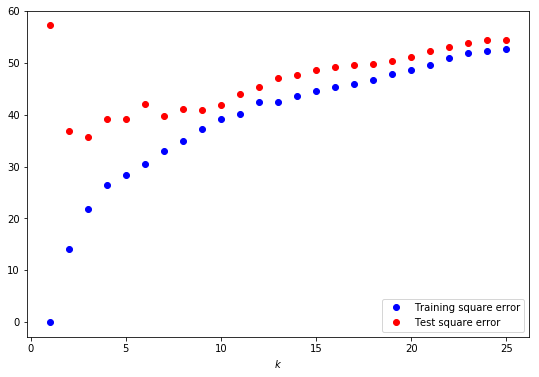

In [11]:
max_k = 25
n_neighbors_list = np.arange(max_k)+1

MSE_train = []
MSE_test = []

for n_neighbors in n_neighbors_list:
    knn = neighbors.KNeighborsRegressor(n_neighbors)
    knn.fit(X_train, s_train)

    s_hat_train = knn.predict(X_train)
    s_hat_test = knn.predict(X_test)

    MSE_train.append(square_error(s_train, s_hat_train))
    MSE_test.append(square_error(s_test, s_hat_test))
    
plt.plot(n_neighbors_list, MSE_train,'bo', label='Training square error')
plt.plot(n_neighbors_list, MSE_test,'ro', label='Test square error')
plt.xlabel('$k$')
plt.axis('tight')

plt.legend(loc='best')
plt.show()

Although the above figures illustrate evolution of the training and test MSE for different selections of the number of neighbors, it is important to note that **this figure, and in particular the red points, cannot be used to select the value of such parameter**. Remember that it is only legal to use the test data to assess the final performance of the method, what includes also that any parameters inherent to the method should be adjusted using the train data only.

## 7. Hyperparameter selection via cross-validation

An inconvenient of the application of the $k$-nn method is that the selection of $k$ influences the final error of the algorithm. In the previous experiments, we kept the value of $k$ that minimized the square error on the training set. However, we also noticed that the location of the minimum is not necessarily the same from the perspective of the test data. Ideally, we would like that the designed regression model works as well as possible on future unlabeled patterns that are not available during the training phase. This property is known as <i>generalization</i>. Fitting the training data is only pursued in the hope that we are also indirectly obtaining a model that generalizes well. In order to achieve this goal, there are some strategies that try to guarantee a correct generalization of the model. One of such approaches is known as <b>cross-validation</b> 

Since using the test labels during the training phase is not allowed (they should be kept aside to simultate the future application of the regression model on unseen patterns), we need to figure out some way to improve our estimation of the hyperparameter that requires only training data. Cross-validation allows us to do so by following the following steps:

   - Split the training data into several (generally non-overlapping) subsets. If we use $M$ subsets, the method is referred to as $M$-fold cross-validation. If we consider each pattern a different subset, the method is usually referred to as leave-one-out (LOO) cross-validation.
   - Carry out the training of the system $M$ times. For each run, use a different partition as a <i>validation</i> set, and use the restating partitions as the training set. Evaluate the performance for different choices of the hyperparameter (i.e., for different values of $k$ for the $k$-NN method).
   - Average the validation error over all partitions, and pick the hyperparameter that provided the minimum validation error.
   - Rerun the algorithm using all the training data, keeping the value of the parameter that came out of the cross-validation process.
   
<img src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png">

**Exercise**: Use `Kfold` function from the `sklearn` library to validate parameter `k`. Use a 10-fold validation strategy. What is the best number of neighbors according to this strategy? What is the corresponding MSE averaged over the test data?

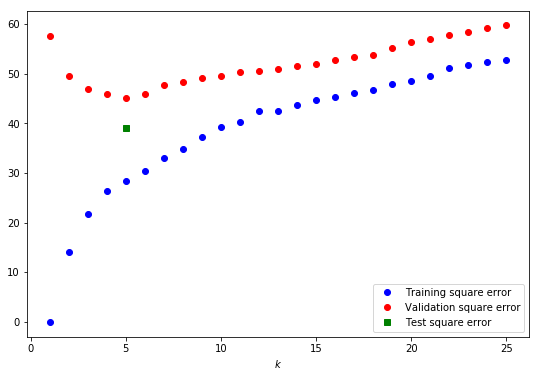

Cross-validation selected the following value for the number of neighbors: 5
Test MSE: 39.1627408867


In [12]:
from sklearn.model_selection import KFold

max_k = 25
n_neighbors_list = np.arange(max_k)+1

MSE_val = np.zeros((max_k,))

nfolds = 10
kf = KFold(n_splits=nfolds)
for train, val in kf.split(X_train):
    for idx,n_neighbors in enumerate(n_neighbors_list):
        knn = neighbors.KNeighborsRegressor(n_neighbors)
        knn.fit(X_train[train,:], s_train[train])

        s_hat_val = knn.predict(X_train[val,:])

        MSE_val[idx] += square_error(s_train[val], s_hat_val)
        
MSE_val = [el/10 for el in MSE_val]

selected_k = np.argmin(MSE_val) + 1

plt.plot(n_neighbors_list, MSE_train,'bo', label='Training square error')
plt.plot(n_neighbors_list, MSE_val,'ro', label='Validation square error')
plt.plot(selected_k, MSE_test[selected_k-1],'gs', label='Test square error')
plt.xlabel('$k$')
plt.axis('tight')

plt.legend(loc='best')
plt.show()

print('Cross-validation selected the following value for the number of neighbors:', selected_k)
print('Test MSE:', MSE_test[selected_k-1])



## 8. A parametric regression method: Least squares regression

### 8.1. Problem definition

   - The goal is to learn a (possibly non-linear) regression model from a set of $L$ labeled points, $\{{\bf x}_k,s_k\}_{k=0}^{K-1}$.
   
   - We assume a parametric function of the form:
   
   $${\hat s}({\bf x}) = f({\bf x}) = w_0 z_0({\bf x}) + w_1 z_1({\bf x}) + \dots w_{m-1} z_{m-1}({\bf x})$$
   
   where $z_i({\bf x})$ are particular transformations of the input vector variables.

Some examples are:
   
   - If ${\bf z} = {\bf x}$, the model is just a linear combination of the input variables

   - If ${\bf z} = \left[\begin{array}{c}1\\{\bf x}\end{array}\right]$, we have again a linear combination with the inclusion of a constant term.



   - For unidimensional input $x$, ${\bf z} = [1, x, x^2, \dots,x^{M}]^\top$ would implement a polynomia of degree $m-1$.



   - Note that the variables of ${\bf z}$ could also be computed combining different variables of ${\bf x}$. E.g., if ${\bf x} = [x_1,x_2]^\top$, a degree-two polynomia would be implemented with 
      $${\bf z} = \left[\begin{array}{c}1\\x_1\\x_2\\x_1^2\\x_2^2\\x_1 x_2\end{array}\right]$$      

   - The above expression does not assume a polynomial model. For instance, we could consider ${\bf z} = [\log(x_1),\log(x_2)]$

Least squares (LS) regression finds the coefficients of the model with the aim of minimizing the square of the residuals. If we define ${\bf w} = [w_0,w_1,\dots,w_M]^\top$, the LS solution would be defined as
    
\begin{equation}{\bf w}_{LS} = \arg \min_{\bf w} \sum_{k=0}^{K-1} e_k^2 = \arg \min_{\bf w} \sum_{k=0}^{K-1} \left[s_k - {\hat s}_k \right]^2 \end{equation}

### 8.2. Vector Notation

In order to solve the LS problem it is convenient to define the following vectors and matrices:

   - We can group together all available target values to form the following vector
   
   $${\bf s} = \left[s_0, s_1, \dots, s_{K-1} \right]^\top$$




   - The estimation of the model for a single input vector ${\bf z}_k$ (which would be computed from ${\bf x}_k$), can be expressed as the following inner product
   
   $${\hat s}_k = {\bf z}_k^\top {\bf w}$$

   - If we now group all input vectors into a matrix ${\bf Z}$, so that each row of ${\bf Z}$ contains the transpose of the corresponding ${\bf z}_k$, we can express
   
$$
\hat{{\bf s}} 
    = \left[{\hat s}_0, {\hat s}_1, \dots, {\hat s}_{K-1} \right]^\top 
    = {\bf Z} {\bf w}, \;\;\;\; \text{with} \;\; 
{\bf Z} = \left[\begin{array}{c} {\bf z}_0^\top \\ 
                                 {\bf z}_1^\top \\
                                 \vdots  \\ 
                                 {\bf z}_{K-1}^\top \\
                \end{array}\right]$$

### 8.3. Least-squares solution

   - Using the previous notation, the cost minimized by the LS model can be expressed as
   
   $$C({\bf w}) = \sum_{k=0}^{K-1} \left[s_k - {\hat s}_k \right]^2 = \|{\bf s} - {\hat{\bf s}}\|^2 = \|{\bf s} - {\bf Z}{\bf w}\|^2$$
   

   - Since the above expression depends quadratically on ${\bf w}$ and is non-negative, we know that there is only one point where the derivative of $C({\bf w})$ becomes zero, and that point is necessarily a minimum of the cost
   
   $$\nabla_{\bf w} \|{\bf s} - {\bf Z}{\bf w}\|^2\Bigg|_{{\bf w} = {\bf w}_{LS}} = {\bf 0}$$

<b>Exercise:</b>
Solve the previous problem to show that
$${\bf w}_{LS} = \left( {\bf Z}^\top{\bf Z} \right)^{-1} {\bf Z}^\top{\bf s}$$

The next fragment of code adjusts polynomia of increasing order to randomly generated training data. 

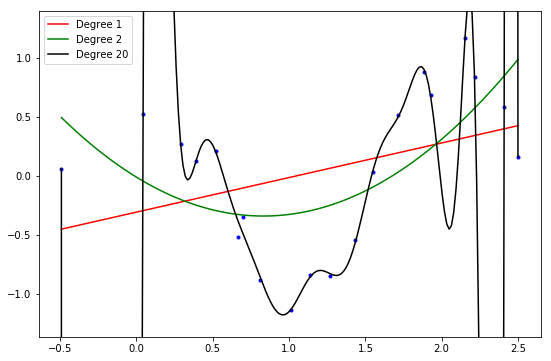

In [13]:
n_points = 20
n_grid = 200
frec = 3
std_n = 0.2
max_degree = 20

colors = 'brgcmyk'

#Location of the training points
X_tr = (3 * np.random.random((n_points,1)) - 0.5)

#Labels are obtained from a sinusoidal function, and contaminated by noise
S_tr = np.cos(frec*X_tr) + std_n * np.random.randn(n_points,1)

#Equally spaced points in the X-axis
X_grid = np.linspace(np.min(X_tr),np.max(X_tr),n_grid)

#We start by building the Z matrix
Z = []
for el in X_tr.tolist():
    Z.append([el[0]**k for k in range(max_degree+1)])
Z = np.matrix(Z)

Z_grid = []
for el in X_grid.tolist():
    Z_grid.append([el**k for k in range(max_degree+1)])
Z_grid = np.matrix(Z_grid)

plt.plot(X_tr,S_tr,'b.')

for k in [1, 2, n_points]: # range(max_degree+1):
    Z_iter = Z[:,:k+1]

    # Least square solution
    #w_LS = (np.linalg.inv(Z_iter.T.dot(Z_iter))).dot(Z_iter.T).dot(S_tr)
    
    # Least squares solution, with leass numerical errors
    w_LS, resid, rank, s = np.linalg.lstsq(Z_iter, S_tr)
    #estimates at all grid points
    fout = Z_grid[:,:k+1].dot(w_LS)
    fout = np.array(fout).flatten()
    plt.plot(X_grid,fout,colors[k%len(colors)]+'-',label='Degree '+str(k))

plt.legend(loc='best')
plt.ylim(1.2*np.min(S_tr), 1.2*np.max(S_tr))
plt.show()

It may seem that increasing the degree of the polynomia is always beneficial, as we can implement a more expressive function. A polynomia of degree $M$ would include all polynomia of lower degrees as particular cases. However, if we increase the number of parameters without control, the polynomia would eventually get expressive enough to adjust any given set of training points to arbitrary precision, what does not necessarily mean that the solution is obtaining a model that can be extrapolated to new data.

The conclusions is that, when adjusting a parametric model using least squares, we need to validate the model, for which we can use the cross-validation techniques we introudece in Section 7. In this contexts, validating the model implies:
   - Validating the kind of model that will be used, e.g., linear, polynomial, logarithmic, etc ... 
   - Validating any additional parameters that the nodel may have, e.g., if selecting a polynomial model, the degree of the polynomia.
   
The code below shows the performance of different models. However, no validation process is considered, so the reported test MSEs could not be used as criteria to select the best model.

In [14]:
# Linear model with no bias
w_LS, resid, rank, s = np.linalg.lstsq(X_train, s_train)
s_hat_test = X_test.dot(w_LS)
print('Test MSE for linear model without bias:', square_error(s_test, s_hat_test))

# Linear model with no bias
Z_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
Z_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))

w_LS, resid, rank, s = np.linalg.lstsq(Z_train, s_train)
s_hat_test = Z_test.dot(w_LS)
print('Test MSE for linear model with bias:', square_error(s_test, s_hat_test))

# Polynomial model degree 2
Z_train = np.hstack((np.ones((X_train.shape[0],1)), X_train, X_train**2))
Z_test = np.hstack((np.ones((X_test.shape[0],1)), X_test, X_test**2))

w_LS, resid, rank, s = np.linalg.lstsq(Z_train, s_train)
s_hat_test = Z_test.dot(w_LS)
print('Test MSE for polynomial model (order 2):', square_error(s_test, s_hat_test))



Test MSE for linear model without bias: 25.8546625564
Test MSE for linear model with bias: 25.7971648592
Test MSE for polynomial model (order 2): 19.2626529893
